# Robert Kramer
## Statistical Learning 3
## Bayesian inference for clustering of MRI data
### 06-15-17

# Standard Model

Use K-means to initialize and EM to segment brain scan image

In [1]:
from PIL import Image
from scipy import stats
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

Read in an image from Lisa's data

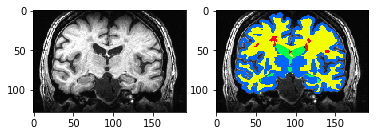

In [64]:
im_lisa = mpimg.imread("./data/001_4.bmp")
plt.subplot(121)
plt.imshow(im_lisa)
im_seg_lisa = mpimg.imread("./data/001_4_seg.bmp")
plt.subplot(122)
plt.imshow(im_seg_lisa)
plt.show()

Find out what the segmented color channel values are. 

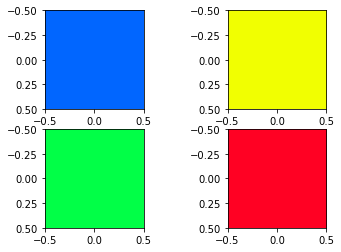

In [5]:
# getting one pixel
plt.subplot(221)
plt.imshow(im_seg_lisa[80:81, 50:51]) 
# Blue [1, 102, 255] grey matter (1)
plt.subplot(222)
plt.imshow(im_seg_lisa[85:86, 50:51]) 
# Yellow [241, 255, 1] white matter (2)
plt.subplot(223)
plt.imshow(im_seg_lisa[50:51, 80:81]) 
# Green array([[[  1, 255,  71]]], dtype=uint8) csf (3)
plt.subplot(224)
plt.imshow(im_seg_lisa[33:34, 70:71])
# Red array([[[255,   1,  35]]], dtype=uint8) disease (4)
plt.show()

Get the x and y coordinates and pixel value for all segmented values.
Get the pixel values of the neighbors
Set the remaining values to black

In [9]:
def get_image_data(image, seg_image):
    '''
    Turns everything black that is not segmented.
    Works for lisa's data
    
    The image is greyscale so channels are equal
        We only need 1 number to represent all of it
    
    '''
    crds = [] # saves a tuple ((x,y),lable)
    neighbors = [] # saves pixel value of neighbors for EM
    for i in range(len(seg_image)):
        for j in range(len(seg_image[1])):
            if tuple(seg_image[i,j]) == (1, 102, 255):
                crds.append((i,j,image[i,j][0],1)) # one value grayscale
                # grey matter
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),1))
                # [sub for each in im[(i-3):(i+2),(j-3):(j+2),1] for sub in each]
            elif tuple(seg_image[i,j]) == (241, 255, 1):
                crds.append((i,j,image[i,j][0],2))
                # white
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),2))
            elif tuple(seg_image[i,j]) == (1, 255, 71):
                crds.append((i,j,image[i,j][0],3))
                # csf
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),3))
            elif tuple(seg_image[i,j]) == (255, 1, 35):
                crds.append((i,j,image[i,j][0],4))
                # disease
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),4))
            else:
                seg_image[i,j] = 1
                image[i,j] = 1
    coords = np.empty((len(crds),4))
    neighbors_data = np.empty((len(crds),26))
    for i in range(len(crds)):
        coords[i] = crds[i]
        neighbors_data[i] = np.append(neighbors[i][0],neighbors[i][1])
    return coords.astype(int), neighbors_data.astype(int)

In [10]:
data_test, neighbors_d = get_image_data(im_lisa, im_seg_lisa)

Now the images have black backgrounds

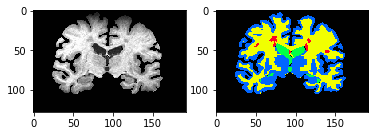

In [11]:
plt.subplot(121)
plt.imshow(im_lisa)
plt.subplot(122)
plt.imshow(im_seg_lisa)
plt.show()

Get all the data from the Lisa's images in the "./data" folder

In [12]:
def get_all_data():
    directory = os.fsencode("./data")
    image_names = []
    seg_image_names = []
    images = []
    images_seg = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".bmp"): 
            if filename.endswith("seg.bmp"): 
                seg_image_names.append(filename)
            else:
                image_names.append(filename)
        else:
            continue
    images.append(mpimg.imread("./data/"+image_names[0]))
    images_seg.append(mpimg.imread("./data/"+seg_image_names[0]))
    data_coord, data_neigh = get_image_data(images[0], images_seg[0])
    for i in range(1,len(image_names)):
        images.append(mpimg.imread("./data/"+image_names[i])) 
        images_seg.append(mpimg.imread("./data/"+seg_image_names[i]))
        data_coord1, data_neigh1 = get_image_data(images[i], images_seg[i])
        data_coord = np.append(data_coord, data_coord1,0)
        data_neigh = np.append(data_neigh, data_neigh1,0)
    return data_coord, data_neigh, images, images_seg

data_coord, data_neigh, images, images_seg = get_all_data()

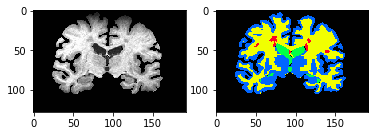

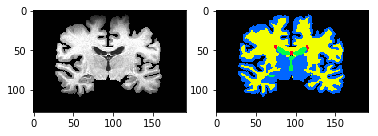

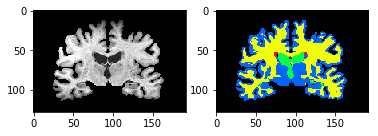

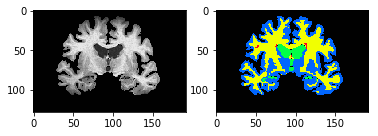

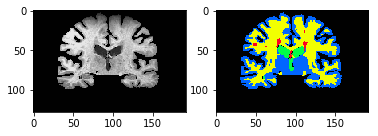

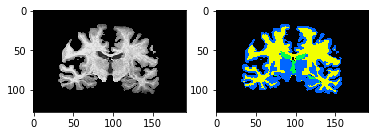

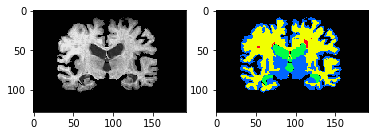

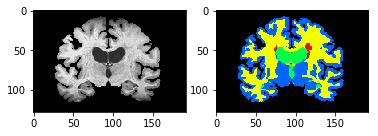

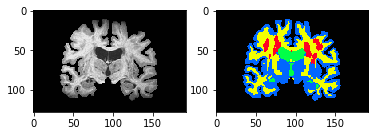

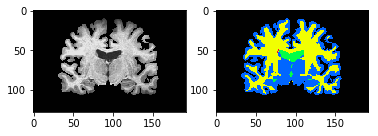

In [20]:
for i in range(len(images)):
    plt.subplot(1,2,1)
    plt.imshow(images[i])
    plt.subplot(1,2,2)
    plt.imshow(images_seg[i])
    plt.show()

# Baseline model
## Initialize with K-means

In [49]:
def d2(x, m):
    d2 = np.dot((x-m).T, (x-m))
    return d2


# M is the centroid matrix :np array
# data is unlabeled np array
def initial_centroids(data, num_of_cen):
    M = np.zeros(num_of_cen*len(data[0]))
    for i in range(len(M)):
        M[i]=np.random.choice(range(int(data.min()),int(data.max()+1)))
    return M.reshape(num_of_cen,len(data[0]))

def membership(data, M):
    mem = np.zeros(len(data),dtype=int)
    dist = np.zeros((len(data), len(M)))
    for i in range(len(data)):
        for j in range(len(M)):
            dist[i][j] = d2(data[i],M[j])
        mem[i] = dist[i].argmin()
    return mem#, dist

# np data, M
# returns float SSE, SSS
def sse(data, M):
    errors = np.zeros(len(data))
    mem = membership(data, M)
    for i in range(len(data)):
        errors[i] = d2(data[i], M[mem[i]])
    return np.sum(errors)


def sss(M):
    sss = 0
    for e in itertools.combinations(M, 2):
        sss += d2(e[0], e[1])
    return sss


# np array inputs 
# takes data and membership list to update M
# uncomment else to reinitialize clusters with zero membership
# -- not that effective and centers may not converge.
def update_centroids(data, M, mem):
    M = np.copy(M)
    for i in range(len(M)):
        C = data[mem==i]
        if len(C) > 0:
            M[i]=np.sum(C, axis=0)/float(len(C))
#        else:
#            M[i]=initial_centroids(data, 1)
    return M

def find_clusters(data, num_of_cen):
    print("NEW TRIAL")
    M0 = initial_centroids(data, num_of_cen)
#    M0 = initialize_with_random_seed(data, num_of_cen)  # uncomment to seed centroids from data
    count = 0
    while True:
        mem0 = membership(data, M0)
        M1 = update_centroids(data, M0, mem0)
        if sse(M0,M1) < .00000001: #or count > 50:
            break
        count+=1
        print(sse(data,M1)," ", count, "sse of Cs", sse(M0,M1))
        M0 = M1
    return M1

In [50]:
M1 = find_clusters(neighbors_d[:,:25], 4)

NEW TRIAL
469373910.615   1 sse of Cs 475582.342547
409982639.269   2 sse of Cs 18892.7640232
406803855.905   3 sse of Cs 1081.80312028
406365460.533   4 sse of Cs 188.043411028
406232642.127   5 sse of Cs 53.6311859232
406138712.274   6 sse of Cs 34.3944281421
406062751.424   7 sse of Cs 25.3452330567
405999371.8   8 sse of Cs 21.9958233864
405936135.081   9 sse of Cs 18.3946372724
405872026.958   10 sse of Cs 21.8776789765
405809315.471   11 sse of Cs 22.4265310523
405746340.711   12 sse of Cs 19.3857576911
405662568.387   13 sse of Cs 29.9508512894
405559464.755   14 sse of Cs 33.791191835
405454102.186   15 sse of Cs 42.1502156425
405331140.561   16 sse of Cs 46.682285547
405248574.823   17 sse of Cs 39.5804313402
405182461.681   18 sse of Cs 26.8454418381
405134091.735   19 sse of Cs 21.0826726463
405097619.428   20 sse of Cs 12.5889087258
405039495.391   21 sse of Cs 22.7048812741
404979949.228   22 sse of Cs 25.9175352287
404920786.218   23 sse of Cs 24.8555899954
404868357.675 

In [34]:
M1

array([[  96.67217176,   85.44426094,   74.59207267,   65.41618497,
          64.37654831,  112.62427746,  107.7192403 ,  101.66391412,
          90.25681255,   80.52436003,  136.56069364,  137.60776218,
         133.10074319,  121.80016515,  106.5639967 ,  156.90668869,
         157.45169282,  152.60693642,  148.1552436 ,  139.55986788,
         170.28819158,  169.85796862,  166.06028076,  160.53674649,
         151.92815855],
       [ 157.46325998,  166.55650877,  172.00335696,  173.45020515,
         170.43342037,  155.48041775,  165.35882134,  169.5307721 ,
         170.46325998,  168.26258859,  149.9380828 ,  158.76240209,
         162.94740768,  164.45244312,  162.53897799,  141.6076091 ,
         149.10070869,  153.80716151,  158.20813129,  157.3923909 ,
         143.76314808,  146.58187244,  148.75941813,  149.82954122,
         149.30883999],
       [ 208.4851232 ,  211.10018596,  211.88702929,  210.87192004,
         208.10297536,  213.12459321,  215.27219898,  215.72245467,


In [35]:
# adapted from mvn_EM - Casey Nold


import csv
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import operator


In [51]:
means = M1
data = np.append(neighbors_d, data_test[:,:2],1)
d = data[:,:25]


In [53]:
len(d[1])
means

array([[ 155.507724  ,  157.70236869,  155.8297288 ,  151.01613457,
         143.88122211,  162.77171301,  164.25025747,  161.80260899,
         156.69756265,  147.94919327,  165.48506694,  165.12907655,
         161.96498455,  157.81119121,  149.5166495 ,  163.12530038,
         162.81565396,  160.72193615,  158.70854789,  153.38379677,
         161.72296601,  161.30621353,  159.4771713 ,  156.32234809,
         151.34225884],
       [ 208.94405757,  212.02669452,  213.07265552,  212.44777159,
         210.15482823,  212.85329619,  215.67014856,  216.53133705,
         215.7402507 ,  213.43337976,  214.1130455 ,  216.93616527,
         217.99651811,  217.113974  ,  214.56383473,  212.56592386,
         215.81963788,  217.04178273,  216.13300836,  213.42873723,
         209.38347261,  211.77831941,  212.74930362,  212.04921077,
         209.71146704],
       [  71.04581673,   85.03286853,  111.84860558,  140.5438247 ,
         158.90737052,   54.51792829,   78.6752988 ,  115.81175299,


In [54]:
n = len(d)
p = len(d[1])
K = 4
mu_init = np.zeros((K,p))
mu_init[0,] = means[0]
mu_init[1,] = means[1]
mu_init[2,] = means[2]
mu_init[3,] = means[3]

In [55]:
pi = np.array([1,1,1,1])/K
sigma_1 = sigma_2 = sigma_3 = sigma_4 = np.identity(p)
sigma = [sigma_1,sigma_2,sigma_3,sigma_4]

r = np.zeros((n,K))
R = np.sum(r,axis=0)

In [56]:
# initialize sigma
for k in range(0,K):
        h = 0
        g = 0
        for i in range(0,n):
            h+= r[i,k]*(d[i,]*d[i,].transpose())
        sigma[k] = np.diag(np.abs(g - (mu_init[k]*mu_init[k].transpose())))

# initialize responsibility matrix
b = 0
for i in range(0,n):
    b= (pi[0]*mvnorm.pdf(d[i],mu_init[0],sigma[0]) +
        pi[1]*mvnorm.pdf(d[i],mu_init[1],sigma[1]) +
        pi[2]*mvnorm.pdf(d[i],mu_init[2],sigma[2]))
    for k in range(0,K):
        r[i,k] = (pi[k]*mvnorm.pdf(d[i],mu_init[k],sigma[k]))/b



-1122333.59858
0
-1070944.90689
1
-1032782.5929
2
-1005730.15015
3
-985892.944746
4


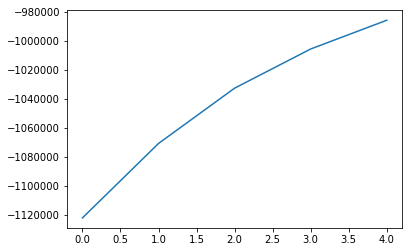

In [58]:
sentry = 0
ll = []
while(sentry < 5):
    
    # E
    for i in range(0,n):
        b= (pi[0]*mvnorm.pdf(d[i],mu_init[0],sigma[0]) +
            pi[1]*mvnorm.pdf(d[i],mu_init[1],sigma[1]) +
            pi[2]*mvnorm.pdf(d[i],mu_init[2],sigma[2]) +
            pi[2]*mvnorm.pdf(d[i],mu_init[3],sigma[3])
           )
        for k in range(0,K):
            r[i,k] = (pi[k]*mvnorm.pdf(d[i],mu_init[k],sigma[k]))/b


    R = np.sum(r,axis=0)
    pi = R/n

    # mu update
    for k in range(0,K):
        lh = 0
        if(R[k] != 0):
            for i in range(0,n):
                lh+=(r[i,k]*d[i,])
            mu_init[k,] = (lh/R[k])


    # sigma update. 
    for k in range(0,K):
        h = 0
        g = 0
        for i in range(0,n):
            h+= r[i,k]*(d[i,]*d[i,].transpose())
        g = h/R[k]
        sigma[k] = np.diag(np.abs(g - (mu_init[k]*mu_init[k].transpose())))
   
    ll_prior = 0
    for i in range(0,n):
        for k in range(0,K):
            ll_prior += r[i,k]*np.log(pi[k])

    ll_param = 0
    for k in range(0,K):
        for i in range(0,n):
            ll_param += r[i,k]*mvnorm.logpdf(d[i,],mu_init[k],sigma[k]) #

    print(ll_param + ll_prior)
    ll.append((ll_param+ll_prior))

    print(sentry)
    sentry += 1
plt.plot(ll)
plt.show()

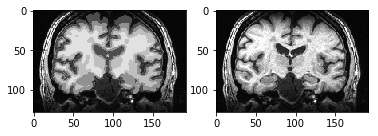

In [67]:
## visualize...

im2 = im_lisa[:]

c = np.zeros((n,p+1))
d = np.zeros((n,p))
for i in range(0,n):
    index, value = max(enumerate(r[i,]), key=operator.itemgetter(1))
    c[i,] = np.append(d[i,],(index+1))

for i in range(0,n):
    if(c[i,25] == 1):
        im2[int(data[i,26]),int(data[i,27]),] = np.mean( mu_init[0])
    elif c[i,25] == 2:
        im2[int(data[i,26]),int(data[i,27]),] = np.mean( mu_init[1])
    elif c[i,25] == 3:
        im2[int(data[i,26]),int(data[i,27]),] = np.mean( mu_init[2])
    else:
        im2[int(data[i,26]),int(data[i,27]),] = np.mean( mu_init[3])
plt.subplot(121)
plt.imshow(im2)
plt.subplot(122)
im_lisa = mpimg.imread("./data/001_4.bmp")
plt.imshow(im_lisa)
plt.show()

In [83]:
preds = [np.argmax(r[i]) for i in range(len(r))]
actual = data[:,25]

# need to match clusters
def get_accuracy(y_pred, y_test):
    correct = 0.0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            correct += 1
    return correct / len(y_pred)

get_accuracy(preds, actual)


0.13959522573949143

# Method using variational inference

## ran out of time. Didn't get implemented

# developed from method by James McInerney 

from numpy import *
from matplotlib.pyplot import *
from numpy.linalg.linalg import inv, det
from scipy.special.basic import digamma
import time

def gen(K,N,XDim):
    #K: number of components
    #N: number of data points
    
    mu = array([random.multivariate_normal(zeros(XDim),10*eye(XDim)) for _ in range(K)])
    cov = [0.1*eye(XDim) for _ in range(K)]
    q = random.dirichlet(ones(K)) #component coefficients
    X = zeros((N,XDim)) #observations
    Z = zeros((N,K)) #latent variables
    for n in range(N):
        #decide which component has responsibility for this data point:
        Z[n,:] = random.multinomial(1, q)
        k = Z[n,:].argmax()
        X[n,:] =  random.multivariate_normal(mu[k,:],cov[k])
    return X

def run(X,K,VERBOSE=False):
    #X: observations
    (N,XDim) = shape(X)
    
    #hyperparams:
    alpha0 = 0.1 #prior coefficient count (for Dir)
    beta0 = (1e-20)*1. #variance of mean (smaller: broader the means)
    v0 = XDim+1. #2. #degrees of freedom in inverse wishart
    m0 = zeros(XDim) #prior mean
    W0 = (1e0)*eye(XDim) #prior cov (bigger: smaller covariance)
    
    #params:
    #Z = ones((N,K))/float(K) #uniform initial assignment
    Z = array([random.dirichlet(ones(K)) for _ in range(N)])

    ion()    
    fig = figure(figsize=(10,10))
    ax_spatial = fig.add_subplot(1,1,1) #http://stackoverflow.com/questions/3584805/in-matplotlib-what-does-111-means-in-fig-add-subplot111
    circs = []
                
    
    itr, max_itr = 0, 20
    while itr < max_itr:
        #M-like-step
        NK = Z.sum(axis=0)
        vk = v0 + NK + 1.
        xd = calcXd(Z,X)
        S = calcS(Z,X,xd,NK)
        betak = beta0 + NK
        m = calcM(K,XDim,beta0,m0,NK,xd,betak)
        W = calcW(K,W0,xd,NK,m0,XDim,beta0,S)

        #E-like-step
        mu = Muopt(X,XDim,NK,betak,m,W,xd,vk,N,K) #eqn 10.64 Bishop
        invc = Invcopt(W,vk,XDim,K) #eqn 10.65 Bishop
        pik = Piopt(alpha0,NK) #eqn 10.66 Bishop
        Z = Zopt(XDim, pik, invc, mu, N, K) #eqn 10.46 Bishop
        
        if VERBOSE:
            print( 'itr %i'%itr)
            print('means',m)
            print('Z',Z)
            print('mu',mu)
            print('invc',invc)
            print('exp(pik)',exp(pik))
            print('NK',NK)
            if itr==0:
                sctX = scatter(X[:,0],X[:,1])
                sctZ = scatter(m[:,0],m[:,1],color='r')
            else:
                #ellipses to show covariance of components
                for circ in circs: circ.remove()
                circs = []
                for k in range(K):
                    circ = create_cov_ellipse(S[k], m[k,:],color='r',alpha=0.3) #calculate params of ellipses (adapted from http://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals)
                    circs.append(circ)
                    #add to axes:
                    ax_spatial.add_artist(circ)
                    #make sure components with NK=0 are not visible:
                    if NK[k]<=alpha0: m[k,:] = m[NK.argmax(),:] #put over point that obviously does have assignments
                sctZ.set_offsets(m)
            draw()
            #time.sleep(0.1)
            savefig('./animation/%04d.png'%itr)
        itr += 1
    
    if VERBOSE:
        #keep display:    
        time.sleep(360)
    
    return m,invc,pik,Z
    
    
def calcXd(Z,X):
    #weighted means (by component responsibilites)
    (N,XDim) = shape(X)
    (N1,K) = shape(Z)
    NK = Z.sum(axis=0)
    assert N==N1
    xd = zeros((K,XDim))
    for n in range(N):
        for k in range(K):
            xd[k,:] += Z[n,k]*X[n,:]
    #safe divide:
    for k in range(K):
        if NK[k]>0: xd[k,:] = xd[k,:]/NK[k]
    
    return xd

def calcS(Z,X,xd,NK):
    (N,K)=shape(Z)
    (N1,XDim)=shape(X)
    assert N==N1
    
    S = [zeros((XDim,XDim)) for _ in range(K)]
    for n in range(N):
        for k in range(K):
            B0 = reshape(X[n,:]-xd[k,:], (XDim,1))
            L = dot(B0,B0.T)
            assert shape(L)==shape(S[k]),shape(L)
            S[k] += Z[n,k]*L
    #safe divide:
    for k in range(K):
        if NK[k]>0: S[k] = S[k]/NK[k]
    return S

def calcW(K,W0,xd,NK,m0,XDim,beta0,S):
    Winv = [None for _ in range(K)]
    for k in range(K): 
        Winv[k]  = inv(W0) + NK[k]*S[k]
        Q0 = reshape(xd[k,:] - m0, (XDim,1))
        q = dot(Q0,Q0.T)
        Winv[k] += (beta0*NK[k] / (beta0 + NK[k]) ) * q
        assert shape(q)==(XDim,XDim)
    W = []
    for k in range(K):
        try:
            W.append(inv(Winv[k]))
        except linalg.linalg.LinAlgError:
            print('Winv[%i]'%k, Winv[k])
            raise linalg.linalg.LinAlgError()
    return W

def calcM(K,XDim,beta0,m0,NK,xd,betak):
    m = zeros((K,XDim))
    for k in range(K): m[k,:] = (beta0*m0 + NK[k]*xd[k,:]) / betak[k]
    return m    

def Muopt(X,XDim,NK,betak,m,W,xd,vk,N,K):
    Mu = zeros((N,K))
    for n in range(N):
        for k in range(K):
            A = XDim / betak[k] #shape: (k,)
            B0 = reshape((X[n,:] - m[k,:]),(XDim,1))
            B1 = dot(W[k], B0)
            l = dot(B0.T, B1)
            assert shape(l)==(1,1),shape(l)
            Mu[n,k] = A + vk[k]*l #shape: (n,k)
    
    return Mu

def Piopt(alpha0,NK):
    alphak = alpha0 + NK
    pik = digamma(alphak) - digamma(alphak.sum())
    return pik

def Invcopt(W,vk,XDim,K):
    invc = [None for _ in range(K)]
    for k in range(K):
        dW = det(W[k])
        print('dW',dW)
        if dW>1e-30: ld = log(dW)
        else: ld = 0.0
        invc[k] = sum([digamma((vk[k]+1-i) / 2.) for i in range(XDim)]) + XDim*log(2) + ld
    return invc
        
def Zopt(XDim, exp_ln_pi, exp_ln_gam, exp_ln_mu, N, K):
    Z = zeros((N,K)) #ln Z
    for k in range(K):
        Z[:,k] = exp_ln_pi[k] + 0.5*exp_ln_gam[k] - 0.5*XDim*log(2*pi) - 0.5*exp_ln_mu[:,k]
    #normalise ln Z:
    Z -= reshape(Z.max(axis=1),(N,1))
    Z1 = exp(Z) / reshape(exp(Z).sum(axis=1), (N,1))
    return Z1
    

X = d
    
#run VB on the data:
K1 = 4 # num components in inference
mu,invc,pik,Z = run(X,K1)
print('mu',mu)
print('NK',Z.sum(axis=0))

8